In [8]:
from google.colab import drive
drive.mount('/content/drive')

import os

DRIVE_DIR = "/content/drive/MyDrive/acne clean pigmentation wrinkles"
CSV_TRAIN = f"{DRIVE_DIR}/train_split_dedup.csv"
CSV_VAL   = f"{DRIVE_DIR}/val_split_dedup.csv"
MODEL_OUT = f"{DRIVE_DIR}/cnn_skin_multilabel_tuned.keras"

print("✅ Paths ready.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Paths ready.


In [2]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.4 MB/s eta 0:00:00


In [5]:
!pip install keras-tuner -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, accuracy_score
import kerastuner as kt

print("✅ All libraries imported.")

✅ All libraries imported.


/tmp/ipython-input-2194043644.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [12]:
CLASSES = ["acne", "pigmentation", "wrinkles"]

train_df = pd.read_csv(CSV_TRAIN)
val_df   = pd.read_csv(CSV_VAL)

IMG_SIZE = (224, 224)
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col=CLASSES,
    target_size=IMG_SIZE,
    class_mode="raw",
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col=CLASSES,
    target_size=IMG_SIZE,
    class_mode="raw",
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("✅ Data generators ready.")

Found 3562 validated image filenames.
Found 955 validated image filenames.
✅ Data generators ready.


In [13]:
def build_model(hp):
    model = Sequential()

    # Smaller search space to reduce memory usage
    num_conv_layers = hp.Int('num_conv_layers', 2, 3, default=2)  # Reduced from 2-4 to 2-3

    # First convolutional block with smaller filters
    filters = hp.Int('filters_1', 16, 64, step=16, default=32)  # Reduced max filters

    for i in range(num_conv_layers):
        if i == 0:
            model.add(Conv2D(filters, (3,3), activation='relu', input_shape=(224,224,3)))
        else:
            # Smaller filter growth
            filters = min(filters * 2, 128)  # Cap at 128 instead of unlimited
            model.add(Conv2D(filters, (3,3), activation='relu'))

        model.add(BatchNormalization())
        model.add(MaxPooling2D(2,2))
        model.add(Dropout(0.2))  # Add dropout between conv layers

    model.add(Flatten())

    # Smaller dense units
    dense_units = hp.Int('dense_units', 64, 256, step=64, default=128)  # Reduced max
    model.add(Dense(dense_units, activation='relu'))

    dropout_rate = hp.Float('dropout_rate', 0.3, 0.5, step=0.1, default=0.4)
    model.add(Dropout(dropout_rate))

    model.add(Dense(len(CLASSES), activation='sigmoid'))

    # Optimizer choices
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])  # Removed 1e-2

    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

print("✅ Memory-efficient HyperModel defined.")

✅ Memory-efficient HyperModel defined.


In [14]:
# Clear session before tuning
tf.keras.backend.clear_session()

# Initialize the tuner with fewer trials
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=8,  # Reduced from 15 to 8
    executions_per_trial=1,
    directory=DRIVE_DIR,
    project_name='skin_cnn_tuning_memory_efficient'
)

print("🚀 Starting memory-efficient hyperparameter search...")

# Perform the search with fewer epochs
tuner.search(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)  # Reduced patience
    ],
    verbose=1
)

print("✅ Hyperparameter search completed!")

Trial 8 Complete [00h 00m 09s]

Best val_accuracy So Far: 0.8209424018859863
Total elapsed time: 01h 14m 00s
✅ Hyperparameter search completed!


In [16]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("🎯 BEST HYPERPARAMETERS FOUND:")
print(f"Number of Conv Layers: {best_hps.get('num_conv_layers')}")
print(f"Initial Filters: {best_hps.get('filters_1')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Optimizer: {best_hps.get('optimizer')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

🎯 BEST HYPERPARAMETERS FOUND:
Number of Conv Layers: 3
Initial Filters: 32
Dense Units: 192
Dropout Rate: 0.5
Optimizer: rmsprop
Learning Rate: 0.0001


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 192)            │    16,613,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           579 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,708,291 (63.74 MB)

 Trainable params: 16,707,843 (63.74 MB)

 Non-trainable params: 448 (1.75 KB)

In [18]:
# Clear session before final training
tf.keras.backend.clear_session()

# Setup callbacks
ckpt = ModelCheckpoint(
    MODEL_OUT,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lrred = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

print("🏋️ Training best model with memory monitoring...")

# Train with smaller steps per epoch if needed
history = best_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,  # You can keep this at 30
    callbacks=[ckpt, early, lrred],
    verbose=1
)

print("✅ Best model training completed!")

🏋️ Training best model with memory monitoring...
Epoch 1/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.5832 - loss: 0.8167
Epoch 1: val_loss improved from inf to 2.35144, saving model to /content/drive/MyDrive/acne clean pigmentation wrinkles/cnn_skin_multilabel_tuned.keras
223/223 ━━━━━━━━━━━━━━━━━━━━ 104s 466ms/step - accuracy: 0.5833 - loss: 0.8152 - val_accuracy: 0.7016 - val_loss: 2.3514 - learning_rate: 1.0000e-04
Epoch 2/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.6620 - loss: 0.2962
Epoch 2: val_loss improved from 2.35144 to 1.79868, saving model to /content/drive/MyDrive/acne clean pigmentation wrinkles/cnn_skin_multilabel_tuned.keras
223/223 ━━━━━━━━━━━━━━━━━━━━ 101s 451ms/step - accuracy: 0.6621 - loss: 0.2961 - val_accuracy: 0.7236 - val_loss: 1.7987 - learning_rate: 1.0000e-04
Epoch 3/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.6767 - loss: 0.2435
Epoch 3: val_loss improved from 1.79868 to 0.47429, saving model to /content/d

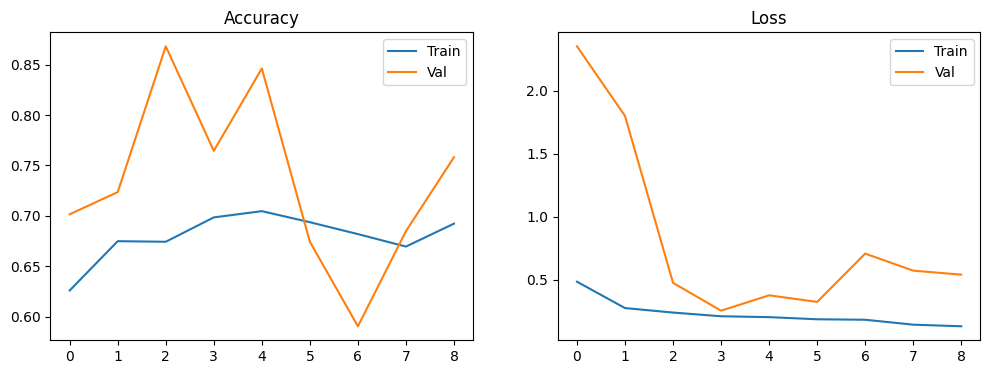

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step
ROC-AUC (macro): 0.9739

Classification Report (thr=0.5)
              precision    recall  f1-score   support

        acne       0.78      0.97      0.86       259
pigmentation       0.91      0.76      0.83        94
    wrinkles       0.89      0.82      0.86       191

   micro avg       0.83      0.88      0.86       544
   macro avg       0.86      0.85      0.85       544
weighted avg       0.84      0.88      0.85       544
 samples avg       0.50      0.50      0.50       544


===== AVERAGE (MACRO) METRICS =====
Accuracy : 0.8723
Precision: 0.8606
Recall   : 0.8488
AUC      : 0.9739


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Val")
plt.title("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Val")
plt.title("Loss"); plt.legend()
plt.show()

# Generate predictions and metrics
val_gen.reset()
preds = best_model.predict(val_gen)
y_true = val_df[CLASSES].values

# Calculate all metrics
roc_auc = roc_auc_score(y_true, preds, average="macro")
y_pred_bin = (preds > 0.5).astype(int)
macro_precision = precision_score(y_true, y_pred_bin, average='macro')
macro_recall = recall_score(y_true, y_pred_bin, average='macro')
macro_acc = accuracy_score(y_true, y_pred_bin)
macro_auc = roc_auc_score(y_true, preds, average='macro')  # This line was missing!

print(f"ROC-AUC (macro): {roc_auc:.4f}")
print("\nClassification Report (thr=0.5)")
print(classification_report(y_true, (preds>0.5).astype(int), target_names=CLASSES))

print("\n===== AVERAGE (MACRO) METRICS =====")
print(f"Accuracy : {macro_acc:.4f}")
print(f"Precision: {macro_precision:.4f}")
print(f"Recall   : {macro_recall:.4f}")
print(f"AUC      : {macro_auc:.4f}")

In [21]:
best_model.save(f"{DRIVE_DIR}/cnn_skin_multilabel_tuned_final.keras")
print("✅ Tuned CNN model saved successfully.")

✅ Tuned CNN model saved successfully.
